In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from plotter import *
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn import BaseESN
# note: you must make this change in the easyesn code
# https://github.com/kalekiu/easyesn/issues/12
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp


""" NOTES:
    This file provides mechanisms to:
    A) Data Processing
        1) Load trajectories from csv files ( file must contain columns 'x', 'y')
        2) Create a trajectory from a trajectory generator (see more documentation in respective function)
        3) Load a generator from a csv file
        4) Load a set of feeders from a csv file
        5) Generate a matrix of place cell activations (row=place cell, column=time_index) 
           pc activation computed according to following formula:
                 e^( log(K) * ||pos - pc_center||^2 / r^2  )
           where 
                r is the place cell's radius
                K is the place cell's activation value at the radius
    
    B) Plot data
        Imports functionalities from 'plotter.py' which uses library matplotlib
"""


# CONSTANTS
PC_VALUE_AT_RADIUS = 0.8  # 0.2 activation value (constant K in pc activation formula)


def load_path(file_name):
    """" load csv fle specifying a path
         file must contain at least columns 'x' and 'y'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return sequence[['x', 'y']].to_numpy()


def load_generator(file_name):
    """" load csv fle specifying a path generator
             file must contain at least columns 'x', 'y' and 'steps'
        """
    return pd.read_csv(file_name, delim_whitespace=True)


def generate_path(generator):
    """ Generate a path using a generator
        'generator' is a pandas data frame containing at least 3 columns 'x' 'y' and 'steps'
        Column 'steps' indicate the number of step to reach the following way point (the
        value in the last row is ignored since it is the last point in the path)
    """

    # convert data to numpy arrays
    xy = generator[['x', 'y']].to_numpy()  # waypoints
    steps = generator['steps'].to_numpy()  #

    # interpolate each segment
    # endpoint=False will avoid repeating the last coordinate of each segment
    interpolator = lambda m_tuple: np.linspace(*m_tuple, endpoint=False)
    data = zip(xy[:-1], xy[1:], steps[:-1])
    path = np.concatenate(list(map(interpolator, data)) + [[xy[-1]]])
    return pd.DataFrame(path, columns=['x', 'y'])


def load_feeders(file_name):
    """"Function to load a set of feeders"""
    return pd.read_csv(file_name, delim_whitespace=True)[['x', 'y']]


def load_place_cells(file_name):
    """" Load csv fle specifying a set of place cells
         file must contain at least columns 'x', 'y' and 'placeradius'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return pcs[['x', 'y']].to_numpy(), pcs['placeradius'].to_numpy()


def calc_activation_matrix(path, pcs):
    """ Calculate a matrix containing the activation of all place cells for all times.
        Each row represents a place cell, while columns represent the time index.
        Both 'pos' and 'pcs' are data frames containing the path and the set of place cells.
    """
    # get number of pcs and position in path
    num_pcs = len(pcs)
    num_pos = len(path)

    # convert data to numpy to operate
    radii = pcs['placeradius'].to_numpy()
    pcs = pcs[['x', 'y']].to_numpy()
    pos = path[['x', 'y']].to_numpy()

    # replicate the position vector by the number of place cells for easy operations
    pos_tile = pos.reshape(1, -1, 2)
    pos_all = np.tile(pos_tile, (num_pcs, 1, 1))

    # replicate the place cells and radii by the number of positions for easy operations
    pcs_tile = pcs.reshape(-1, 1, 2)
    pcs_all = np.tile(pcs_tile, (1, num_pos, 1))
    radii_all = np.tile(radii.reshape((-1, 1)), (1, num_pos))

    # calculate the activations (see description of formula at the top of this file)
    delta = pos_all - pcs_all
    delta2 = (delta * delta).sum(2)
    r2 = radii_all * radii_all
    exponents = np.log(PC_VALUE_AT_RADIUS) * delta2 / r2
    activations = np.exp(exponents)
    return activations







Using Numpy backend.


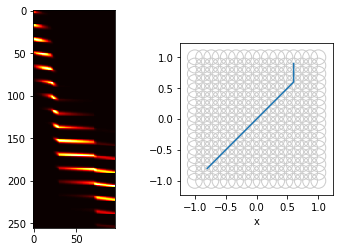

In [2]:
    # test load place cells and a trajectory
    pcs = load_place_cells('input/placecells.csv')
    abcde = load_path('input/abcde.csv')
    feeders = load_feeders('input/feeders.csv')

    # test load generator and generate path using 'sample_path_generator.csv':
    # the generator is a sequence of way points
    # 'steps' indicate the number of steps to reach the next way point
    # note: the number of steps in the last row is ignored
    #   x     |  y     | steps
    # ------------------------
    #   -0.4  |  -0.4  |   7
    #    0    |   0    |  10
    #    0.5  |   0    |  -1

    # note: alternatively you can generate the data like this:
    # sample_generator = pd.DataFrame({'x':     [-0.4,  0,  0.5],
    #                                  'y':     [-0.4,  0,  0  ],
    #                                  'steps': [ 7  , 10, -1  ]})
    
    #modifying to allow two sequences
#    sample_generator = load_generator('input/sample_path_generator.csv')
#    sample_generator2 = load_generator('input/sample_path_generator2.csv')
    sample_generator = load_generator('input/path-y-a')
    sample_generator2 = load_generator('input/path-y-b')
    generated_path = generate_path(sample_generator)
    generated_path2 = generate_path(sample_generator2)

    # test calculation of activation matrix
    # choose sequence: 'generated_path' or 'abcde'
    sequence = generated_path
    activations = calc_activation_matrix(sequence, pcs)
    sequence2 = generated_path2
    activations2 = calc_activation_matrix(sequence2, pcs)

    # test plot utilities
    fig, axs = plt.subplots(1, 2 )
    f1 = axs[0]
    f2 = axs[1]
    f2.autoscale(enable=True)
    f2.set_aspect('equal')
    plot_activation_matrix_heatmap(activations, plot=f1)

    plot_place_cells(pcs, plot=f2)  # add place cells to figure
#    plot_maze(plot=f2)
    plot_path(sequence, plot=f2)
#    plot_feeders(feeders, plot=f2, s=80, zorder=2)  # zorder can be used to move the layer up or down
    plt.savefig('reservoirstates-Y-left.png', dpi = 1200)
    plt.show()



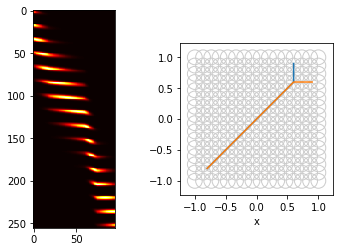

In [3]:
    # test plot utilities
    fig, axs = plt.subplots(1, 2 )
    f1 = axs[0]
    f2 = axs[1]
    f2.autoscale(enable=True)
    f2.set_aspect('equal')
    plot_activation_matrix_heatmap(activations2, plot=f1)

    plot_place_cells(pcs, plot=f2)  # add place cells to figure
#    plot_maze(plot=f2)
    plot_path(sequence, plot=f2)
    plot_path(sequence2, plot=f2)
#    plot_feeders(feeders, plot=f2, s=80, zorder=2)  # zorder can be used to move the layer up or down

    plt.savefig('reservoirstates-Y-right.png')
    plt.show()



In [4]:
np.random.seed(1)
vectorDim = 256
numNode = 400
print(activations.shape)
inputDataTraining = activations.T
outputDataTraining = activations.T
print(inputDataTraining.shape)

(256, 96)
(96, 256)


In [5]:
for num in range(10):
    inputDataTraining = np.append(inputDataTraining, inputDataTraining, axis=0)
print(inputDataTraining.shape)
outputDataTraining=inputDataTraining

(98304, 256)


In [6]:
esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)

In [7]:
esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)

100% (98200 of 98200) |##################| Elapsed Time: 0:00:26 Time:  0:00:26


4.705564921226402e-06

In [8]:
inputDataTesting = activations.T
inputDataTesting2 = activations2.T
print(len(inputDataTesting))
print(len(inputDataTesting2))

96
96


In [9]:
reservoirStatesBuffer = np.empty((0,numNode))
prediction,reservoirStatesBuffer  = esn.predict(inputDataTesting)
reservoirStatesBuffer = reservoirStatesBuffer.T
reservoirStatesBuffer = reservoirStatesBuffer[:,257:]
print(reservoirStatesBuffer.shape)
print(prediction.shape)

(96, 400)
(96, 256)


In [10]:
reservoirStatesBuffer2 = np.empty((0,numNode))
prediction,reservoirStatesBuffer2  = esn.predict(inputDataTesting2)
reservoirStatesBuffer2 = reservoirStatesBuffer2.T
reservoirStatesBuffer2 = reservoirStatesBuffer2[:,257:]
print(reservoirStatesBuffer2.shape)
print(prediction.shape)

(96, 400)
(96, 256)


In [11]:
data = np.empty((len(inputDataTesting)))
data2 = np.empty((len(inputDataTesting)))

# simplify - dont need the whole trajectory, just for the final 
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for num in range(len(inputDataTesting)):
    data[num] = cos_sim(reservoirStatesBuffer[num],reservoirStatesBuffer2[num])
    #data2[num] = np.power(cos_sim(inputDataTestingA[num],inputDataTestingB[num]),3)
    data2[num] = cos_sim(inputDataTesting[num],inputDataTesting2[num])

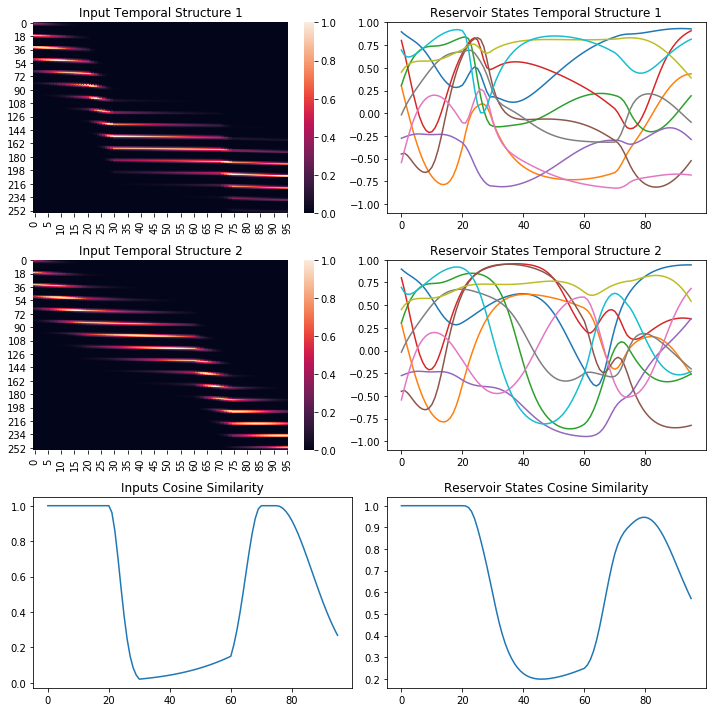

In [12]:
resn = 10
fig= plt.figure(figsize=(10,10))
#fig.suptitle('State Trajectories', fontsize=16)
#fig.suptitle('State Trajectories')

plt.subplot(321)

#plt.plot( inputDataTesting[:76,:])
#sns.heatmap(activations, cmap="seismic")
sns.heatmap(activations)

#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 1')

plt.subplot(323)

#plt.plot( inputDataTesting2[:76,:])
#sns.heatmap(activations2, vmin=0.4, vmax=1)
sns.heatmap(activations2)


#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 2')

plt.subplot(325)
plt.plot( data2)
#plt.ylim([-0.1,0.1])
plt.title('Inputs Cosine Similarity')

plt.subplot(322)
plt.plot( reservoirStatesBuffer[:,:resn])
#plt.plot( inputDataTestingA[:,:5])

plt.ylim([-1.1,1])
plt.title('Reservoir States Temporal Structure 1')

plt.subplot(324)
plt.plot( reservoirStatesBuffer2[:,:resn])
#plt.plot( inputDataTestingB[:,:5])


plt.ylim([-1.1,1])
plt.title('Reservoir States Temporal Structure 2')

plt.subplot(326)
plt.plot( data)
#plt.ylim([-0.1,0.1])
plt.title('Reservoir States Cosine Similarity')

fig.tight_layout()

plt.savefig('reservoirstates-Y-simplified.png')